# Mass Regression Notebook Updated
After preliminary studies done in mass_regression.ipynb we move to this notebook where we have a better understanding of the variables and how to handle them

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import uproot as ur
import awkward as ak
import atlas_mpl_style as ampl
ampl.use_atlas_style()

print('Numpy version: {}'.format(np.__version__))
print('Uproot version: {}'.format(ur.__version__))
print('Awkward version: {}'.format(ak.__version__))

def round_to_sigfigs(value, sigfig=3):
    
    # isntantiate array with same dimensions, return zero where values
    # are zero!
    value = np.array(value)
    returnval = np.zeros(value.shape)
    
    # only do operations on nonzero as we deal with log
    nz_bool = value != 0.0
    exp = np.floor(np.log10(np.abs(value[nz_bool]))).astype(int)
    mantissa = value[nz_bool]/10.0**exp
    new_mantissa = np.round(mantissa, decimals=sigfig-1)

    # return the mantissa back to the appropriate exponential
    returnval[nz_bool] = np.multiply(new_mantissa, 10.0**exp)
    return returnval

Numpy version: 1.23.1
Uproot version: 4.3.3
Awkward version: 1.8.0


This is a gitch in Jupyter. Matplotlib needs a plot object before the rcParams can be set

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tex Gyre Heros, Helvetica, Nimbus Sans, FreeSans, Arial


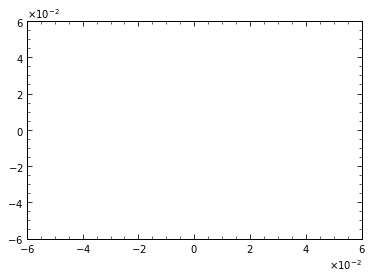

In [2]:
plt.plot()
plt.show()

In [3]:
ampl.use_atlas_style()
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10, 8)
matplotlib.rcParams['xtick.labelsize'] = 16
matplotlib.rcParams['ytick.labelsize'] = 16
matplotlib.rcParams['legend.fontsize'] = 16

In [4]:
rootfile_prefix = '/fast_scratch_1/atlas_images/XhhNTuple/'
rfile = 'user.zhenw.29137978._000001.MiniNTuple.root'
uprooted = ur.open(rootfile_prefix+rfile)
uprooted.keys()

['XhhMiniNtuple;1',
 'cutflow_XhhMiniNtuple;1',
 'cutflow_weighted_XhhMiniNtuple;1',
 'MetaData_EventCount_XhhMiniNtuple;1']

In [5]:
MNTuple = uprooted['XhhMiniNtuple']
# events.arrays(["px1", "py1", "pz1"])
MNTuple.show(name_width=32,
            interpretation_width=30)

name                             | typename                 | interpretation                
---------------------------------+--------------------------+-------------------------------
runNumber                        | int32_t                  | AsDtype('>i4')
eventNumber                      | int64_t                  | AsDtype('>i8')
lumiBlock                        | int32_t                  | AsDtype('>i4')
coreFlags                        | uint32_t                 | AsDtype('>u4')
bcid                             | int32_t                  | AsDtype('>i4')
mcEventNumber                    | int32_t                  | AsDtype('>i4')
mcChannelNumber                  | int32_t                  | AsDtype('>i4')
mcEventWeight                    | float                    | AsDtype('>f4')
NPV                              | int32_t                  | AsDtype('>i4')
actualInteractionsPerCrossing    | float                    | AsDtype('>f4')
averageInteractionsPerCrossing   | float    

## Load Utils

In [6]:
import os
import sys
cwd = os.getcwd()
path_head, path_tail = os.path.split(cwd)
sys.path.append(path_head+'/utils')
from ml_utils import dict_from_tree, DeltaR, tvt_num
from time import perf_counter as cput

In [7]:
kitchen_sink = ['m', 'pt', 'phi', 'eta', 'Split12', 'Split23', 'Split34',
            'tau1_wta', 'tau2_wta', 'tau3_wta', 'tau21_wta', 'tau32_wta',
            'ECF1', 'ECF2', 'ECF3', 'C2', 'D2', 'NTrimSubjets', 'Nclusters',
            'nTracks', 'ungrtrk500', 'EMFrac', 'nChargedParticles',
            'numConstituents']
truthJet_vars = ['truth_mHH', 'truthjet_antikt10_pt', 'truthjet_antikt10_eta',
           'truthjet_antikt10_phi', 'truthjet_antikt10_m']

# These are the substructure variables for which we have no information about
no_info = ['Split34', 'Nclusters', 'EMFrac', 'nChargedParticles']

for i, suffix in enumerate(kitchen_sink):
    kitchen_sink[i] = 'boostedJets_'+suffix
    
for i, suffix in enumerate(no_info):
    no_info[i] = 'boostedJets_'+suffix
        
print('\nNo information about the following:')
print('-'*40)
for name in no_info:
    print(name)
    
# This is the completed list for which we have all information
boostedJets_keys = []
print('\nRelevant substructure variables:')
print('-'*40)
for cutlery in kitchen_sink:
    print(cutlery)
    if not cutlery in no_info:
        boostedJets_keys.append(cutlery)


No information about the following:
----------------------------------------
boostedJets_Split34
boostedJets_Nclusters
boostedJets_EMFrac
boostedJets_nChargedParticles

Relevant substructure variables:
----------------------------------------
boostedJets_m
boostedJets_pt
boostedJets_phi
boostedJets_eta
boostedJets_Split12
boostedJets_Split23
boostedJets_Split34
boostedJets_tau1_wta
boostedJets_tau2_wta
boostedJets_tau3_wta
boostedJets_tau21_wta
boostedJets_tau32_wta
boostedJets_ECF1
boostedJets_ECF2
boostedJets_ECF3
boostedJets_C2
boostedJets_D2
boostedJets_NTrimSubjets
boostedJets_Nclusters
boostedJets_nTracks
boostedJets_ungrtrk500
boostedJets_EMFrac
boostedJets_nChargedParticles
boostedJets_numConstituents


## Load Specified Arrays from NTuple into Dictionary

In [8]:
t0 = cput()
boostedJets_dict = dict_from_tree(MNTuple, kitchen_sink, np_branches=None)
truthJets_dict = dict_from_tree(MNTuple, truthJet_vars, np_branches=None)
t1 = cput()
load_time = t1 - t0
print('Time to load arrays: {:8.4f} (s)'.format(load_time))

nEvents = len(boostedJets_dict['boostedJets_m'])
print('{} Events'.format(nEvents))

Time to load arrays:   2.6553 (s)
339978 Events


### Preliminary Scan for Events With > 2 Jets

In [9]:
gt_twoJets = np.zeros(nEvents, dtype=bool)
t0 = cput()
for i in range(nEvents):
    # just use jet pt as an arbitrary variable to look at how many jets
    boostedJets_pt = ak.to_numpy(boostedJets_dict['boostedJets_pt'][i])
    
    if len(boostedJets_pt) >=2:
        gt_twoJets[i] = True

n2jets = np.count_nonzero(gt_twoJets)
print('Number of events with > 2 jets: {}'.format(n2jets))
print('Number of events total:         {}'.format(nEvents))
print('                                {:5.2f} %'.format(n2jets*100/nEvents))
t1 = cput()
print('time: {:8.2f} (s)'.format(t1 - t0))

Number of events with > 2 jets: 95892
Number of events total:         339978
                                28.21 %
time:    30.14 (s)


## Match Jets

In [10]:
t0 = cput()
# Track the DR between truth jets for leading and subleading
# use -1 as an arbitrary flag
LeadingJet_DR2 = np.full((n2jets,), -1, dtype=np.float64)
subLeadingJet_DR2 = np.full((n2jets,), -1, dtype=np.float64)
matched_jet_bool = np.zeros((n2jets,), dtype=bool)

# int of events with more than two jets
list_indices = np.arange(nEvents)
evt_idx = np.ndarray.copy(list_indices[gt_twoJets])

matched_jets = []
for i, evt in enumerate(evt_idx):
    
    nTruthJets = ak.to_numpy(truthJets_dict['truthjet_antikt10_m'][evt]).shape[0]
    truthJet_coords = np.empty((nTruthJets, 2))
    # this can be vectorized easily (too tired)
    for j in range(nTruthJets):
        truthJet_coords[j,0] = truthJets_dict['truthjet_antikt10_eta'][evt][j]
        truthJet_coords[j,1] = truthJets_dict['truthjet_antikt10_phi'][evt][j]
    
    ## Leading Jet
    BoostedJet0_eta = boostedJets_dict['boostedJets_eta'][evt][0]
    BoostedJet0_phi = boostedJets_dict['boostedJets_phi'][evt][0]
    BoostedJet0_coords = np.array([BoostedJet0_eta, BoostedJet0_phi])
    LeadingJet_DR_arr = DeltaR(truthJet_coords, BoostedJet0_coords)
    
    # Find the deltaR for the leading jet
    LJ_DR = np.min(LeadingJet_DR_arr)
    LJ_DR_idx = np.argmin(LeadingJet_DR_arr)
    LJ_idx_bool = np.ones(LeadingJet_DR_arr.shape, dtype=bool)
    LJ_idx_bool[LJ_DR_idx] = False
    
    # Find the next closest delta R for the next jet ordered in pt
    LJ_DR2 = np.min(LeadingJet_DR_arr[LJ_idx_bool])
    
    ## Subleading Jet
    BoostedJet1_eta = boostedJets_dict['boostedJets_eta'][evt][1]
    BoostedJet1_phi = boostedJets_dict['boostedJets_phi'][evt][1]
    BoostedJet1_coords = np.array([BoostedJet1_eta, BoostedJet1_phi])
    subLeadingJet_DR_arr = DeltaR(truthJet_coords, BoostedJet1_coords)
    
    SLJ_DR = np.min(subLeadingJet_DR_arr)
    SLJ_DR_idx = np.argmin(subLeadingJet_DR_arr)
    SLJ_idx_bool = np.ones(subLeadingJet_DR_arr.shape, dtype=bool)
    SLJ_idx_bool[SLJ_DR_idx] = False
    
    SLJ_DR2 = np.min(subLeadingJet_DR_arr[SLJ_idx_bool])
    
    if SLJ_DR_idx != LJ_DR_idx:
        if LJ_DR < .1 and SLJ_DR < .1:
            matched_jets.append([evt, LJ_DR_idx, SLJ_DR_idx])
            matched_jet_bool[i] = True
            LeadingJet_DR2[i] = LJ_DR2
            subLeadingJet_DR2[i] = SLJ_DR2

t1 = cput()
print('Time to complete jet matching: {:6.3f} (m)'.format((t1 - t0)/60))
print();print()
matched_jets = np.array(matched_jets)
print(matched_jets.shape)

Time to complete jet matching:  1.757 (m)


(94859, 3)


### Inspect Jet Matching
### Check $\Delta R$ to Nearest Jet

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tex Gyre Heros, Helvetica, Nimbus Sans, FreeSans, Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tex Gyre Heros, Helvetica, Nimbus Sans, FreeSans, Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tex Gyre Heros, Helvetica, Nimbus Sans, FreeSans, Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tex Gyre Heros, Helvetica, Nimbus Sans, FreeSans, Arial


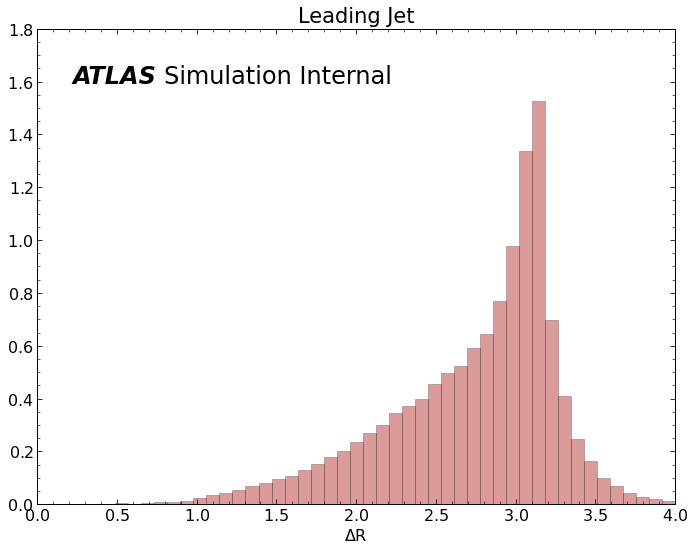

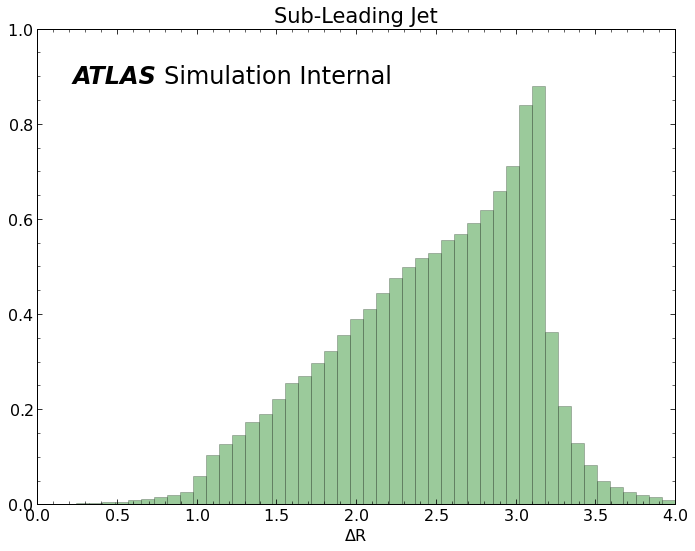

In [11]:
DR2_bins = np.linspace(0,4,num=50, endpoint=True)

plt.hist(LeadingJet_DR2[matched_jet_bool], bins=DR2_bins, density=True,
        edgecolor='black', alpha=.45, color='firebrick')
plt.title('Leading Jet', fontsize=21)
plt.xlabel('$\Delta R$', fontsize=16)
ampl.plot.draw_atlas_label(x=.055, y=.925, ax=plt.gca(), status='int',
                           simulation=True, color='black', fontsize=24)
plt.xlim(np.min(DR2_bins), np.max(DR2_bins))
fig = plt.gcf()
fig.patch.set_facecolor('white')
fig.patch.set_alpha(1.0)
plt.tight_layout()
# plt.savefig('Plots/Presentation_Feb23/DR_LeadingJet.png')
plt.show()

plt.hist(subLeadingJet_DR2[matched_jet_bool], bins=DR2_bins, density=True,
        edgecolor='black', alpha=.45, color='forestgreen')
plt.title('Sub-Leading Jet', fontsize=21)
plt.xlabel('$\Delta R$', fontsize=16)
ampl.plot.draw_atlas_label(x=.055, y=.925, ax=plt.gca(), status='int',
                           simulation=True, color='black', fontsize=24)
plt.xlim(np.min(DR2_bins), np.max(DR2_bins))
plt.xlim(np.min(DR2_bins), np.max(DR2_bins))
fig = plt.gcf()
fig.patch.set_facecolor('white')
fig.patch.set_alpha(1.0)
plt.tight_layout()
# plt.savefig('Plots/Presentation_Feb23/DR_SubLeadingJet.png')
plt.show()

## Fill arrays with inputs

### Update Event Indices to Handle NAN
Notes: Working on fixing this such that we actually update 

In [12]:
boostedJets_norm_info = np.empty((len(boostedJets_keys), 2), dtype=np.float64)

matched_evt_indices = np.ndarray.copy(matched_jets[:,0])
matched_jet_indices = np.ndarray.copy(matched_jets[:,1:3])

''' We can iteratively figure out what events have substructure variables which
contain nan values by searching leading and subleading jets '''
# start assuming all events are fine so nan boolean is all False
# this is the length of the matched indices
evt_nan_bool = np.full((matched_evt_indices.shape[0],), False, dtype=bool)
t0 = cput()
for jetVar in boostedJets_keys:
    np_slice = ak.to_numpy(boostedJets_dict[jetVar]
                           [matched_evt_indices,:2])
    
    lead_jet_bool = np.isnan(np_slice[:,0])
    sublead_jet_bool = np.isnan(np_slice[:,1])
    
    # condense this to either jet having a nan in the substructure variable
    jets_bool = np.logical_or(lead_jet_bool, sublead_jet_bool)
    # update the event bool - sort of a memory for each substructure
    evt_nan_bool = np.logical_or(evt_nan_bool, jets_bool)
t1 = cput()

print(' {:6.2f} (s)'.format(t1 - t0))

# we have an array which points to events which have nans. Invert this
# to find the good values for matched jets
evt_notNan_bool = np.invert(evt_nan_bool)
old_matched_evt_indices = np.ndarray.copy(matched_evt_indices)
matched_evt_indices = np.ndarray.copy(matched_evt_indices[evt_notNan_bool])
## Update Matched Jets!!! ##
matched_jets = np.ndarray.copy(matched_jets[evt_notNan_bool,:])

old_evt_num = old_matched_evt_indices.shape[0]
new_evt_num = matched_evt_indices.shape[0]
print('Before NaN test: {}'.format(old_evt_num))
print('After NaN test: {}'.format(new_evt_num))
print('Efficiency: {:5.2f} %'.format(new_evt_num*100/old_evt_num))

print('\nPeek at matched jets info')
print(matched_jets.shape)
print(matched_jets[:5,:])

   0.09 (s)
Before NaN test: 94859
After NaN test: 94741
Efficiency: 99.88 %

Peek at matched jets info
(94741, 3)
[[ 1  0  1]
 [ 3  0  1]
 [ 9  0  1]
 [14  0  1]
 [20  0  1]]


### Mean and Standard Deviation Dictionary
Note this is only for the relevant variables

In [13]:
## SIGNIFICANT FIGURES HERE FOR NORMALIZATION
SIG_FIGS = 4

# boostedJets_mean_dict is a dictionary with an array containing the mean and
# standard deviation of all the relevant substructure variables
boostedJets_mean_dict = dict()
matched_evt_indices = matched_jets[:,0]
matched_jet_indices = matched_jets[:,1:3]

t0 = cput()
for var in boostedJets_keys:
    
    np_slice = ak.to_numpy(boostedJets_dict[var]
                           [matched_evt_indices,:2])
    
    flat_arr = np_slice.flatten()
    nan_bool = np.isnan(flat_arr)
    if np.any(nan_bool):
        raise ValueError('found nans')
        
    jetVar_mean = np.mean(flat_arr)
    jetVar_std = np.std(flat_arr)
    
    boostedJets_mean_dict[var] = round_to_sigfigs([jetVar_mean, jetVar_std], sigfig=SIG_FIGS)
t1 = cput()

print(' {:6.2f} (s)'.format(t1 - t0))

np.set_printoptions(precision=4, suppress=True)
for key, item in boostedJets_mean_dict.items():
    snstring = [np.format_float_scientific(x, precision=3, sign=True) for x in item]
    print('{:30s}-  {}'.format(key, snstring))

   0.10 (s)
boostedJets_m                 -  ['+1.105e+02', '+2.706e+01']
boostedJets_pt                -  ['+5.878e+02', '+2.677e+02']
boostedJets_phi               -  ['-3.557e-03', '+1.813e+00']
boostedJets_eta               -  ['-9.388e-04', '+8.341e-01']
boostedJets_Split12           -  ['+6.193e+01', '+2.715e+01']
boostedJets_Split23           -  ['+1.215e+01', '+8.905e+00']
boostedJets_tau1_wta          -  ['+1.601e-01', '+8.122e-02']
boostedJets_tau2_wta          -  ['+4.805e-02', '+3.098e-02']
boostedJets_tau3_wta          -  ['+3.055e-02', '+1.959e-02']
boostedJets_tau21_wta         -  ['+3.221e-01', '+1.528e-01']
boostedJets_tau32_wta         -  ['+6.322e-01', '+1.451e-01']
boostedJets_ECF1              -  ['+5.707e+02', '+2.581e+02']
boostedJets_ECF2              -  ['+3.118e+07', '+1.965e+07']
boostedJets_ECF3              -  ['+2.262e+11', '+5.188e+11']
boostedJets_C2                -  ['+1.247e-01', '+5.655e-02']
boostedJets_D2                -  ['+1.301e+00', '+1.22e+00

## Show All Substructure Variables
 - agnostic of leading versus subleading

In [14]:
## Load the plotting dictionary from the designated module
from plotting_module import plot_dict_list as pdl
print(len(kitchen_sink))
print(len(pdl))
plot_dict_raw = dict(zip(kitchen_sink, pdl))

24
24


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tex Gyre Heros, Helvetica, Nimbus Sans, FreeSans, Arial



-- All Variables --
----------------------------------------
boostedJets_m
boostedJets_pt
boostedJets_phi
boostedJets_eta
boostedJets_Split12
boostedJets_Split23
boostedJets_Split34
boostedJets_tau1_wta
boostedJets_tau2_wta
boostedJets_tau3_wta
boostedJets_tau21_wta
boostedJets_tau32_wta
boostedJets_ECF1
boostedJets_ECF2
boostedJets_ECF3
boostedJets_C2
boostedJets_D2
boostedJets_NTrimSubjets
boostedJets_Nclusters
boostedJets_nTracks
boostedJets_ungrtrk500
boostedJets_EMFrac
boostedJets_nChargedParticles
boostedJets_numConstituents


boostedJets_m
----------------------------------------


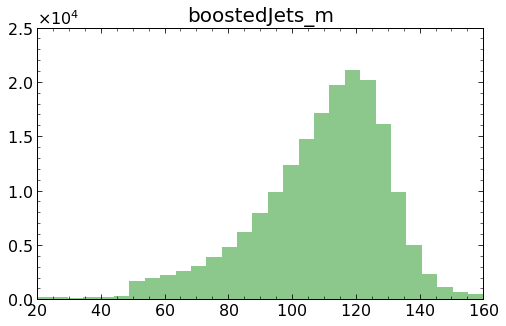

 0: boostedJets_m mean/std
----------------------------------------
 mean: +1.105e+02
 std:  +2.706e+01
----------------------------------------


boostedJets_pt
----------------------------------------


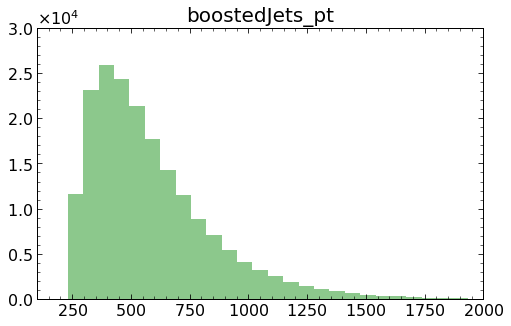

 1: boostedJets_pt mean/std
----------------------------------------
 mean: +5.878e+02
 std:  +2.677e+02
----------------------------------------


boostedJets_phi
----------------------------------------


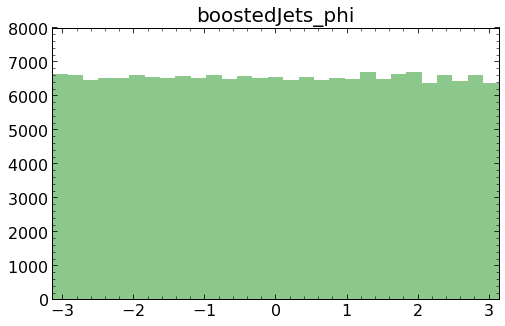

 2: boostedJets_phi mean/std
----------------------------------------
 mean: -3.557e-03
 std:  +1.813e+00
----------------------------------------


boostedJets_eta
----------------------------------------


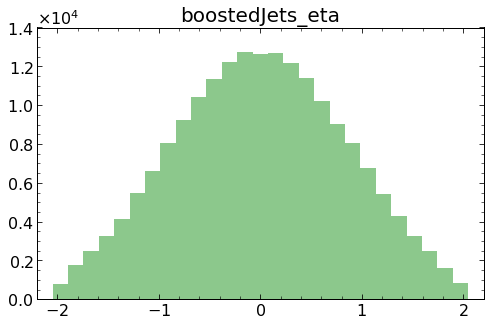

 3: boostedJets_eta mean/std
----------------------------------------
 mean: -9.388e-04
 std:  +8.341e-01
----------------------------------------


boostedJets_Split12
----------------------------------------


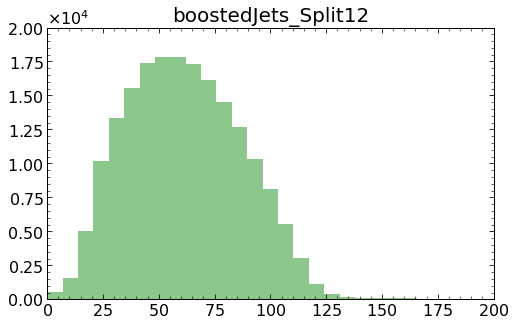

 4: boostedJets_Split12 mean/std
----------------------------------------
 mean: +6.193e+01
 std:  +2.715e+01
----------------------------------------


boostedJets_Split23
----------------------------------------


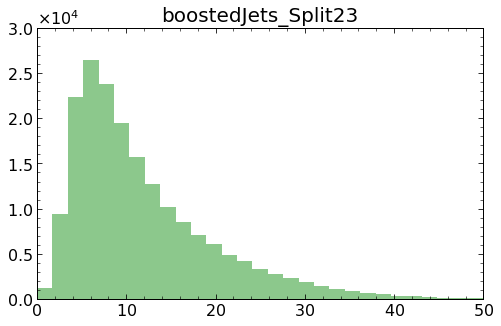

 5: boostedJets_Split23 mean/std
----------------------------------------
 mean: +1.215e+01
 std:  +8.905e+00
----------------------------------------


boostedJets_Split34
----------------------------------------


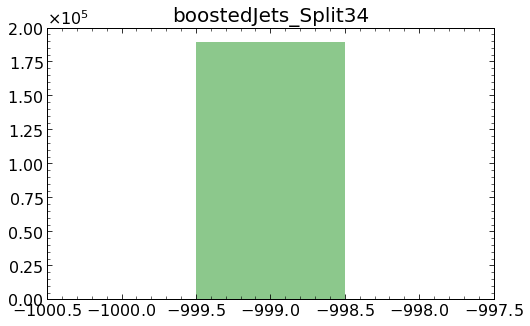

 6: boostedJets_Split34 mean/std
----------------------------------------
 mean: N/A
 std:  N/A
----------------------------------------


boostedJets_tau1_wta
----------------------------------------


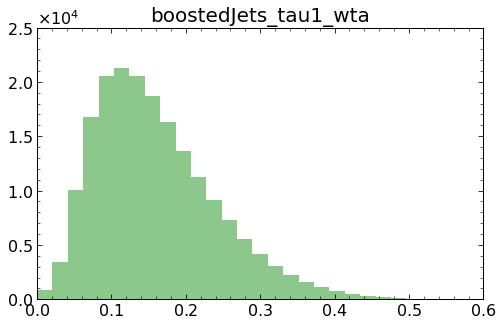

 7: boostedJets_tau1_wta mean/std
----------------------------------------
 mean: +1.601e-01
 std:  +8.122e-02
----------------------------------------


boostedJets_tau2_wta
----------------------------------------


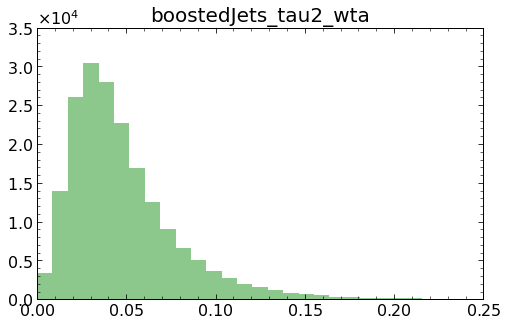

 8: boostedJets_tau2_wta mean/std
----------------------------------------
 mean: +4.805e-02
 std:  +3.098e-02
----------------------------------------


boostedJets_tau3_wta
----------------------------------------


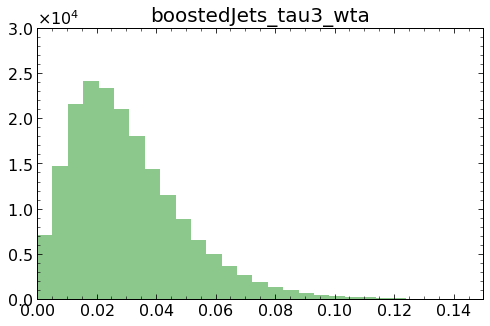

 9: boostedJets_tau3_wta mean/std
----------------------------------------
 mean: +3.055e-02
 std:  +1.959e-02
----------------------------------------


boostedJets_tau21_wta
----------------------------------------


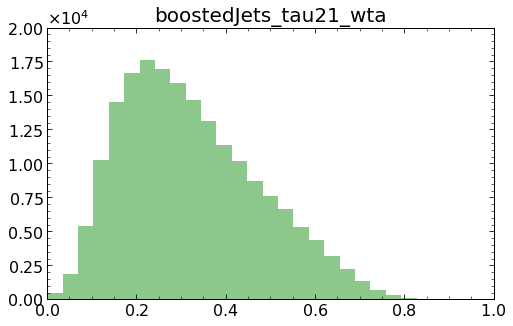

 10: boostedJets_tau21_wta mean/std
----------------------------------------
 mean: +3.221e-01
 std:  +1.528e-01
----------------------------------------


boostedJets_tau32_wta
----------------------------------------


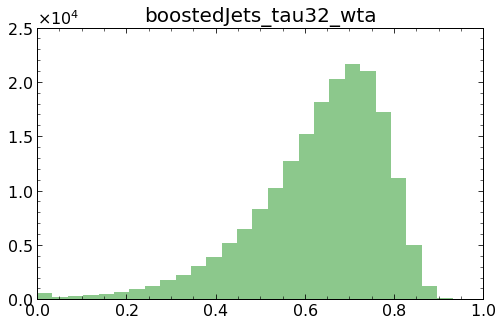

 11: boostedJets_tau32_wta mean/std
----------------------------------------
 mean: +6.322e-01
 std:  +1.451e-01
----------------------------------------


boostedJets_ECF1
----------------------------------------


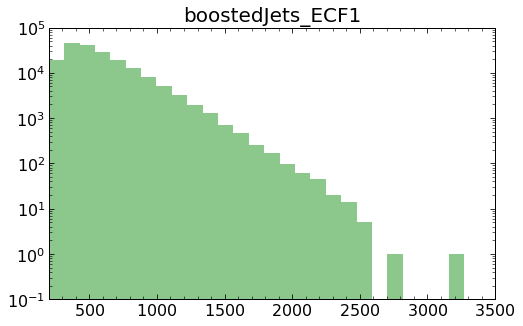

 12: boostedJets_ECF1 mean/std
----------------------------------------
 mean: +5.707e+02
 std:  +2.581e+02
----------------------------------------


boostedJets_ECF2
----------------------------------------


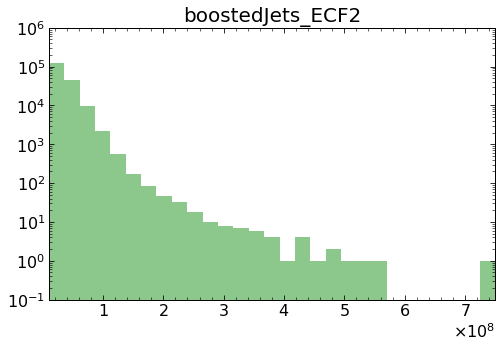

 13: boostedJets_ECF2 mean/std
----------------------------------------
 mean: +3.118e+07
 std:  +1.965e+07
----------------------------------------


boostedJets_ECF3
----------------------------------------


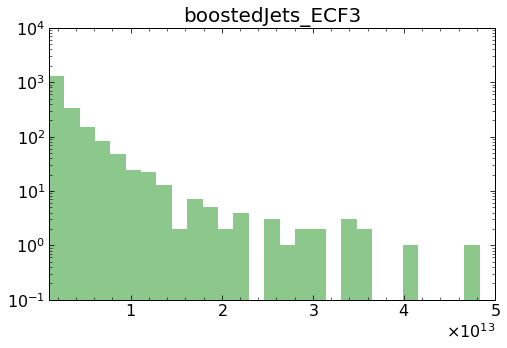

 14: boostedJets_ECF3 mean/std
----------------------------------------
 mean: +2.262e+11
 std:  +5.188e+11
----------------------------------------


boostedJets_C2
----------------------------------------


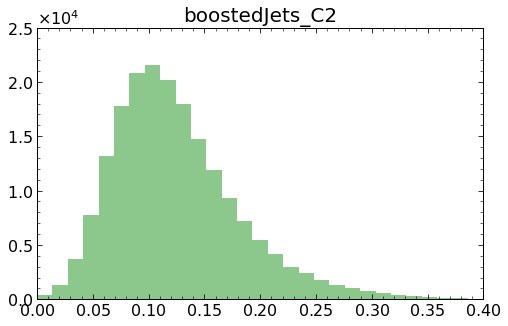

 15: boostedJets_C2 mean/std
----------------------------------------
 mean: +1.247e-01
 std:  +5.655e-02
----------------------------------------


boostedJets_D2
----------------------------------------


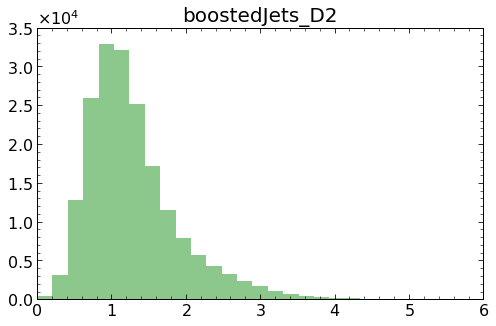

 16: boostedJets_D2 mean/std
----------------------------------------
 mean: +1.301e+00
 std:  +1.22e+00
----------------------------------------


boostedJets_NTrimSubjets
----------------------------------------


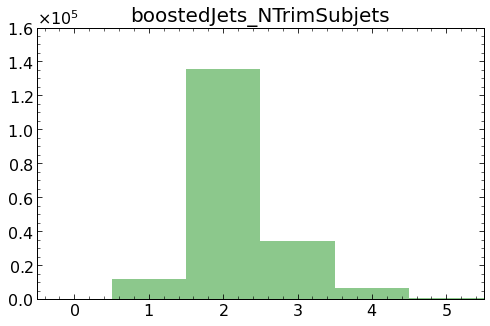

 17: boostedJets_NTrimSubjets mean/std
----------------------------------------
 mean: +2.206e+00
 std:  +6.346e-01
----------------------------------------


boostedJets_Nclusters
----------------------------------------


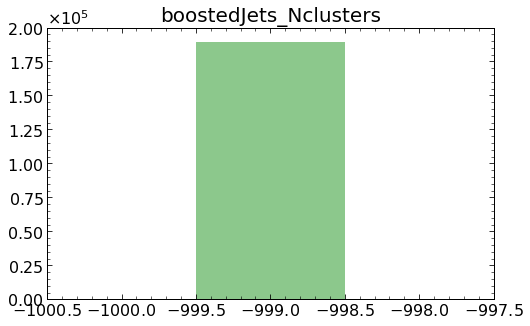

 18: boostedJets_Nclusters mean/std
----------------------------------------
 mean: N/A
 std:  N/A
----------------------------------------


boostedJets_nTracks
----------------------------------------


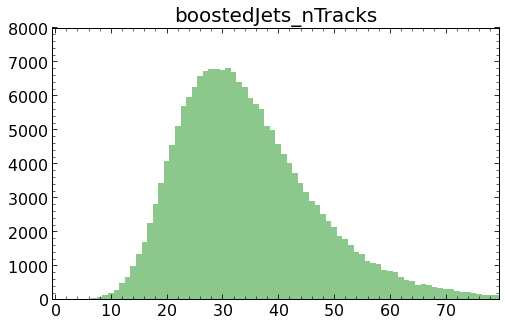

 19: boostedJets_nTracks mean/std
----------------------------------------
 mean: +3.479e+01
 std:  +1.286e+01
----------------------------------------


boostedJets_ungrtrk500
----------------------------------------


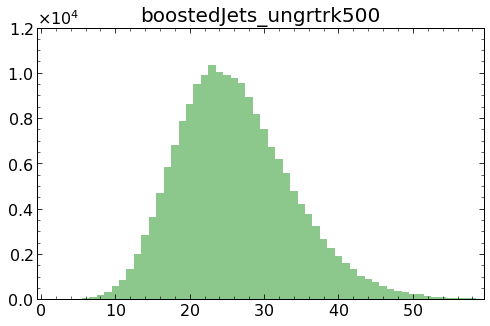

 20: boostedJets_ungrtrk500 mean/std
----------------------------------------
 mean: +2.616e+01
 std:  +7.749e+00
----------------------------------------


boostedJets_EMFrac
----------------------------------------


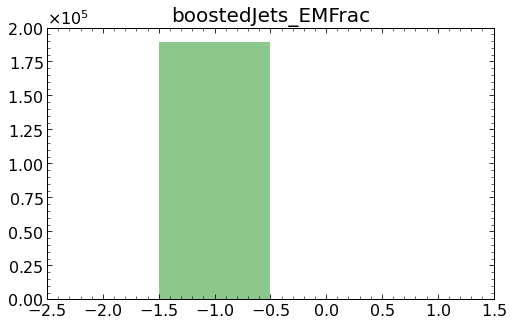

 21: boostedJets_EMFrac mean/std
----------------------------------------
 mean: N/A
 std:  N/A
----------------------------------------


boostedJets_nChargedParticles
----------------------------------------


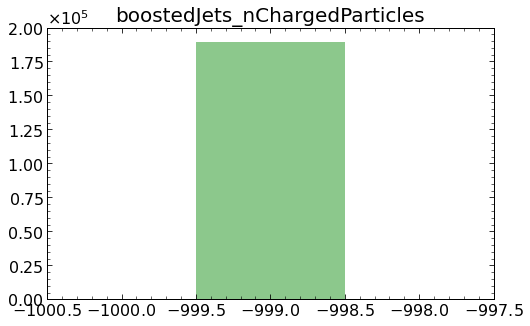

 22: boostedJets_nChargedParticles mean/std
----------------------------------------
 mean: N/A
 std:  N/A
----------------------------------------


boostedJets_numConstituents
----------------------------------------


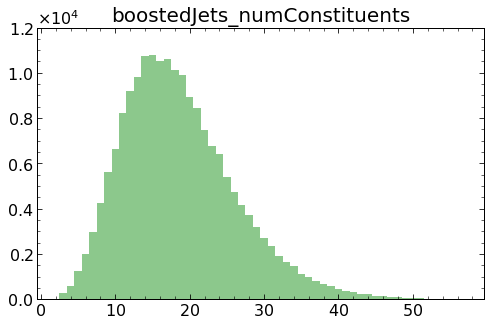

 23: boostedJets_numConstituents mean/std
----------------------------------------
 mean: +1.862e+01
 std:  +7.585e+00
----------------------------------------



In [15]:
print()
print('-- All Variables --')
print('-'*40)
for cutlery in kitchen_sink:
    print(cutlery)

print()
idx = 0
for j, cutlery in enumerate(kitchen_sink):
    flat_arr = ak.to_numpy(boostedJets_dict[cutlery]
                           [matched_evt_indices,:2]).flatten()
    
    if cutlery in boostedJets_keys:
        ksj_mean = boostedJets_mean_dict[cutlery][0]
        ksj_std = boostedJets_mean_dict[cutlery][1]
    else:
        ksj_mean = None
        ksj_std = None
    
    print('\n{}'.format(cutlery))
    print('-'*40)
    fig = plt.figure(figsize=(8,5))
    
    thisplot_bins = plot_dict_raw[cutlery]['bins']
    plt.hist(flat_arr, bins=thisplot_bins, alpha=.45)
    plt.xlim(thisplot_bins[0], thisplot_bins[-1])
    
    if plot_dict_raw[cutlery]['semilogy']:
        plt.semilogy()
    plt.title(cutlery, fontsize=20)
    plt.show()
    print(' {}: {} mean/std'.format(j,cutlery))
    print('-'*40)
    if ksj_mean is not None:
        meanstr = np.format_float_scientific(ksj_mean, precision=SIG_FIGS-1, sign=True)
        stdstr = np.format_float_scientific(ksj_std, precision=SIG_FIGS-1, sign=True)
        print(' mean: {}'.format(meanstr))
        print(' std:  {}'.format(stdstr))
    else:
        print(' mean: N/A')
        print(' std:  N/A')
    print('-'*40);print()

## Build Normalized Dictionary with Relevant Values Only

We can construct an array of normalization data for only the boosted jet
substructure variables for which we have information for. During the inspection
of all the variables, we can just simply re-test for nans? No this isn't correct
as we wish to check these arrays as we go through all variables... Do this in two
sections


Notes: A note about the variable naming scheme..

boostedJets contains all the information about boosted jet substructure.

boostedJets_keys are ONLY the keys which we care about (other entries have null information)

boostedJets_normalized will contain all the normalized arrays WITH EVENT SELECTION APPLIED!!!

boostedJets_norm_mean will contain all the mean and standard deviations

In [16]:
## After inspecting the variables these are the variables which we want to log scale
log_vars = ['boostedJets_ECF1', 'boostedJets_ECF2', 'boostedJets_ECF3']

## just input these manually because we have seen the distributions
special_case_vars = ['boostedJets_NTrimSubjets', 'boostedJets_nTracks', 'boostedJets_ungrtrk500']
special_case_std = [1, 10, 10]
special_case_std_dict = dict(zip(special_case_vars, special_case_std))

In [17]:
boostedJets_normalized = dict()
boostedJets_norm_mean = dict()
display_vars = True

for key in boostedJets_keys:
    var_mean = boostedJets_mean_dict[key][0]
    var_std = boostedJets_mean_dict[key][1]
    
    # for the slicing: first we take the leading and subleading jet so we have a
    # "rectangular" shape for the array slice, as well as the matched event
    # indices that we found prior
    np_slice = ak.to_numpy(boostedJets_dict[key][matched_evt_indices,:2])

    # Handle log scale variables separately
    if key in log_vars:
        nz_mask = np_slice == 0
        if np.any(nz_mask):
            print('Found zero values in ECF functions!!')
            print('Variable: {}\n'.format(key))
            raise ValueError('Found zero values in ECF functions!!')

        log_slice = np.log(np_slice)
        log_mean = np.mean(log_slice.flatten())
        log_std = np.std(log_slice.flatten())
        
        # need to make a small array for mean and std with same rounding scheme
        mean_sl = round_to_sigfigs([log_mean, log_std], sigfig=SIG_FIGS)
        boostedJets_norm_mean[key] = np.ndarray.copy(mean_sl)

        # set values in the dictionaries
        boostedJets_normalized[key] = (log_slice - log_mean) / log_std

    # discrete variables
    elif key in special_case_vars:
        ''' For now these seem to be the discrete variables, so we
        can get away with dealing with integers '''
        mean_spc = int(np.mean(np_slice))
        std_spc  = special_case_std_dict[key]

        # change these values in the dictionary
        boostedJets_norm_mean[key] = np.array([mean_spc, std_spc])

        # set values in the dictionaries
        boostedJets_normalized[key] = (np_slice - mean_spc) / std_spc

    # normalization procedure for 'normal' continuous variables 
    else:
        # nothing to modify about mean/std, so just make a copy
        boostedJets_norm_mean[key] = np.ndarray.copy(
            boostedJets_mean_dict[key])  
        
        # standard normalization procedure
        boostedJets_normalized[key] = (np_slice - var_mean) / var_std
                       
        
    if display_vars:
        print('-- {} --'.format(key))
        print('-'*40)
        print('mean: {}'.format(boostedJets_norm_mean[key][0]))
        print('std: {}'.format(boostedJets_norm_mean[key][1]))
        print(np_slice.shape)
        print()
if not display_vars:
    print('\nFinished constructing normalized dictionary!\n')

-- boostedJets_m --
----------------------------------------
mean: 110.5
std: 27.06
(94741, 2)

-- boostedJets_pt --
----------------------------------------
mean: 587.8
std: 267.7
(94741, 2)

-- boostedJets_phi --
----------------------------------------
mean: -0.003557
std: 1.813
(94741, 2)

-- boostedJets_eta --
----------------------------------------
mean: -0.0009388
std: 0.8341
(94741, 2)

-- boostedJets_Split12 --
----------------------------------------
mean: 61.92999999999999
std: 27.15
(94741, 2)

-- boostedJets_Split23 --
----------------------------------------
mean: 12.15
std: 8.905
(94741, 2)

-- boostedJets_tau1_wta --
----------------------------------------
mean: 0.16010000000000002
std: 0.08122
(94741, 2)

-- boostedJets_tau2_wta --
----------------------------------------
mean: 0.048049999999999995
std: 0.03098
(94741, 2)

-- boostedJets_tau3_wta --
----------------------------------------
mean: 0.03055
std: 0.01959
(94741, 2)

-- boostedJets_tau21_wta --
-----------

## Plot Normalized Variables

In [18]:
from plotting_module import plot_norm_list as pnl
print(len(boostedJets_keys))
print(len(pnl))
plot_norm_dict = dict(zip(boostedJets_keys, pnl))

20
20


-- boostedJets_m --
----------------------------------------


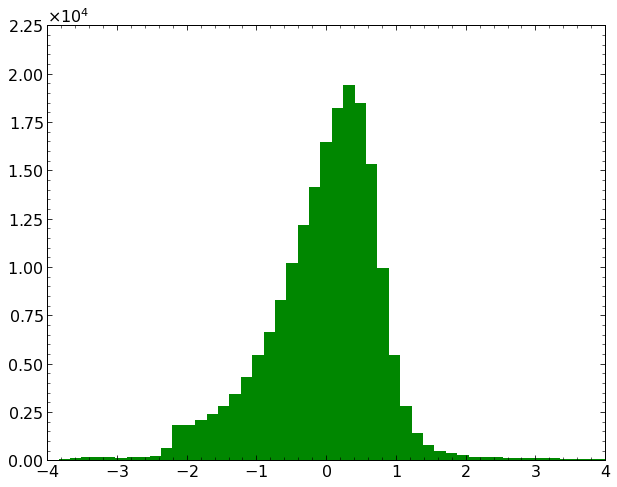

mean: +1.105e+02
std: +2.706e+01

-- boostedJets_pt --
----------------------------------------


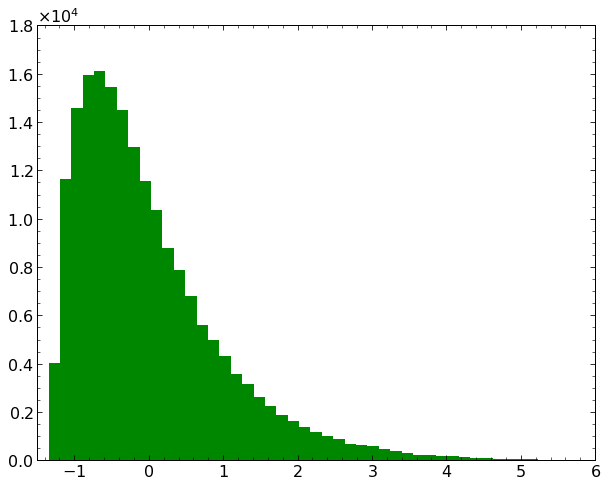

mean: +5.878e+02
std: +2.677e+02

-- boostedJets_phi --
----------------------------------------


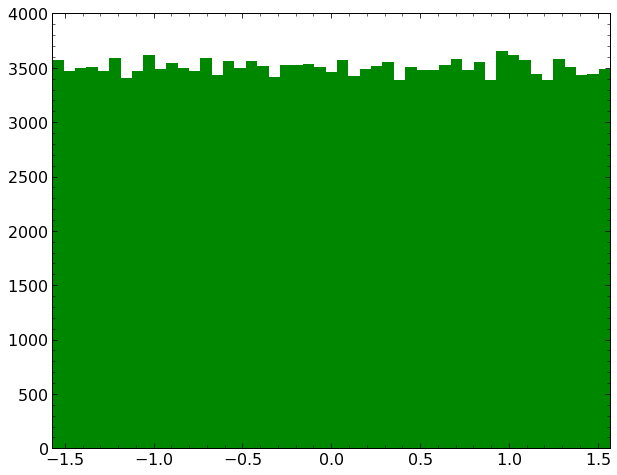

mean: -3.557e-03
std: +1.813e+00

-- boostedJets_eta --
----------------------------------------


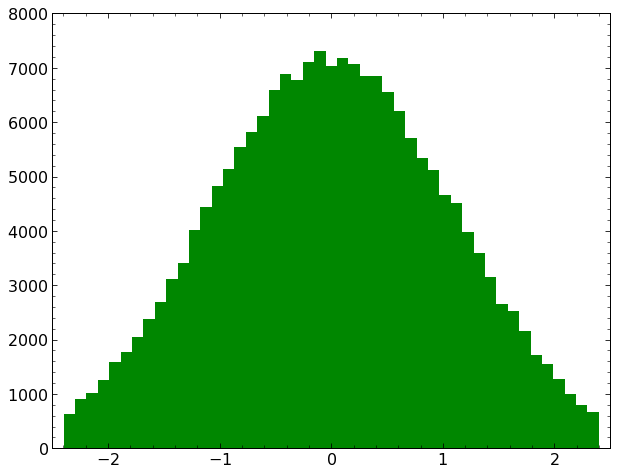

mean: -9.388e-04
std: +8.341e-01

-- boostedJets_Split12 --
----------------------------------------


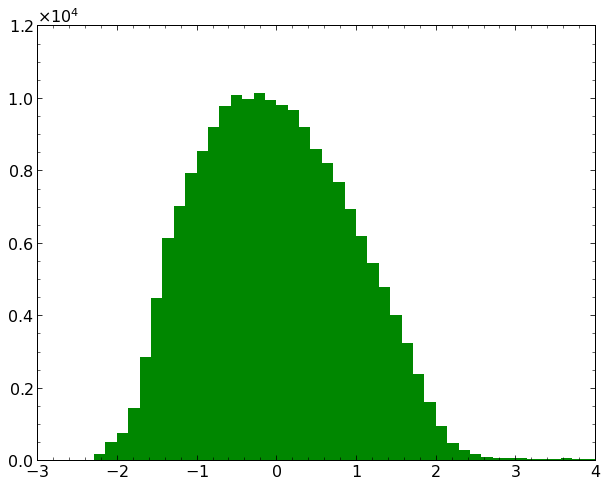

mean: +6.193e+01
std: +2.715e+01

-- boostedJets_Split23 --
----------------------------------------


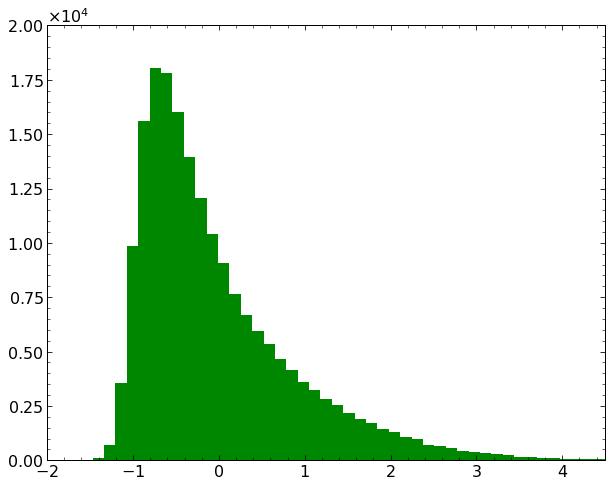

mean: +1.215e+01
std: +8.905e+00

-- boostedJets_tau1_wta --
----------------------------------------


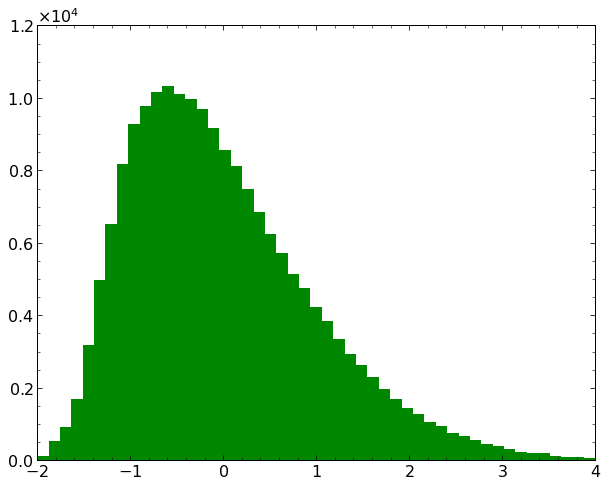

mean: +1.601e-01
std: +8.122e-02

-- boostedJets_tau2_wta --
----------------------------------------


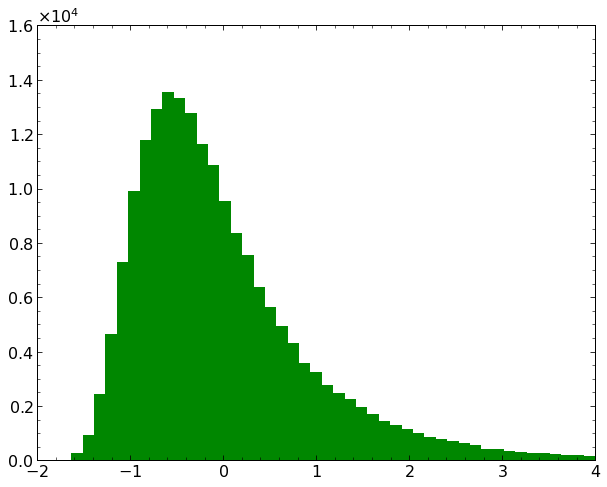

mean: +4.805e-02
std: +3.098e-02

-- boostedJets_tau3_wta --
----------------------------------------


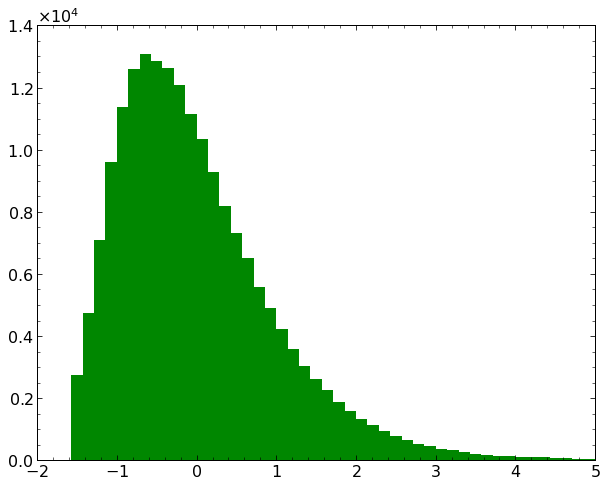

mean: +3.055e-02
std: +1.959e-02

-- boostedJets_tau21_wta --
----------------------------------------


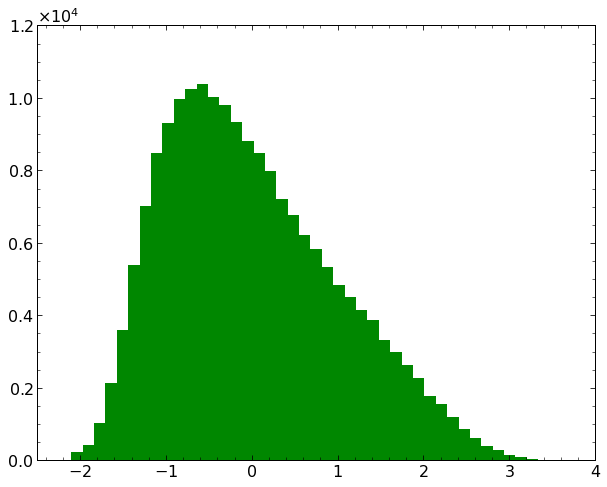

mean: +3.221e-01
std: +1.528e-01

-- boostedJets_tau32_wta --
----------------------------------------


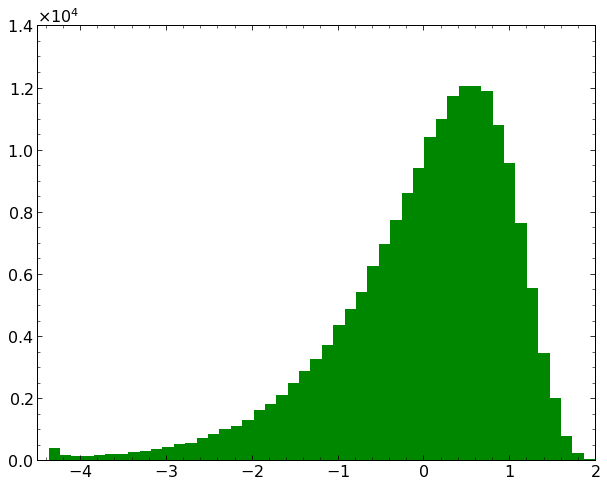

mean: +6.322e-01
std: +1.451e-01

-- boostedJets_ECF1 --
----------------------------------------


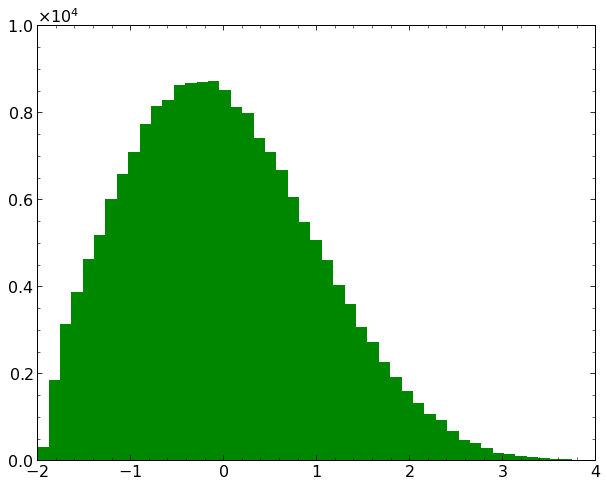

mean: +6.26e+00
std: +4.059e-01

-- boostedJets_ECF2 --
----------------------------------------


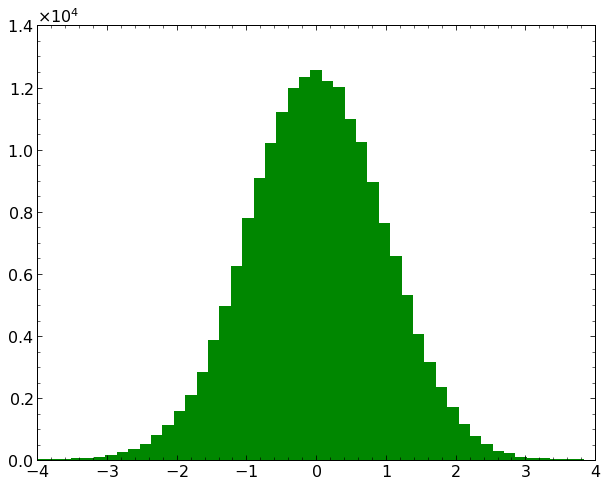

mean: +1.71e+01
std: +5.691e-01

-- boostedJets_ECF3 --
----------------------------------------


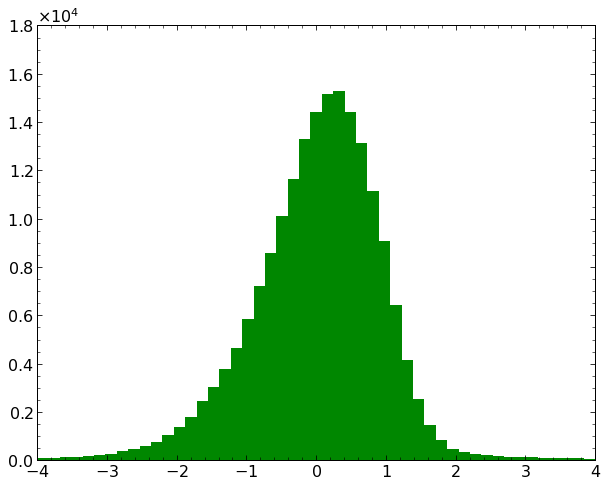

mean: +2.574e+01
std: +9.006e-01

-- boostedJets_C2 --
----------------------------------------


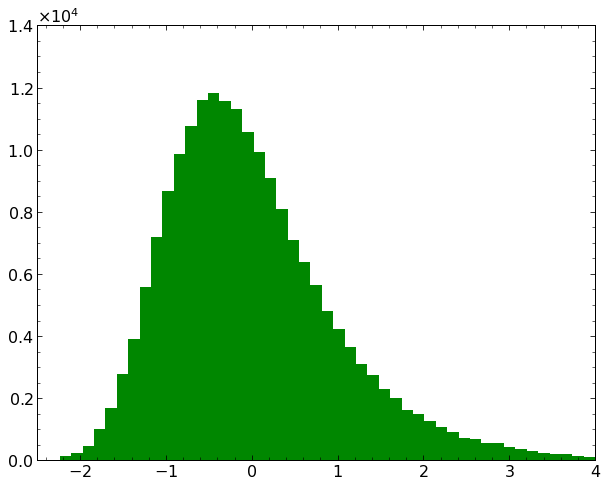

mean: +1.247e-01
std: +5.655e-02

-- boostedJets_D2 --
----------------------------------------


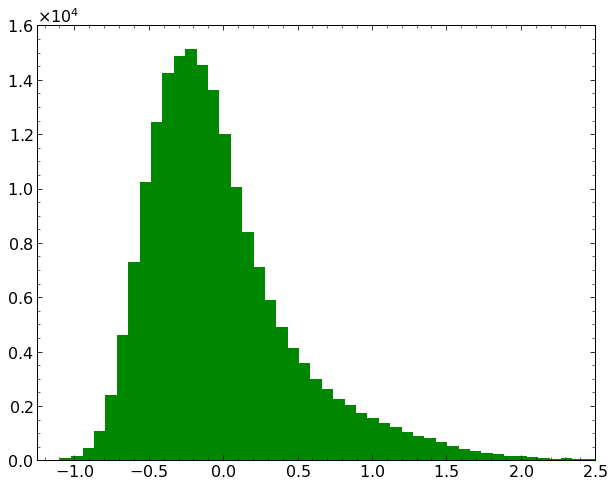

mean: +1.301e+00
std: +1.22e+00

-- boostedJets_NTrimSubjets --
----------------------------------------


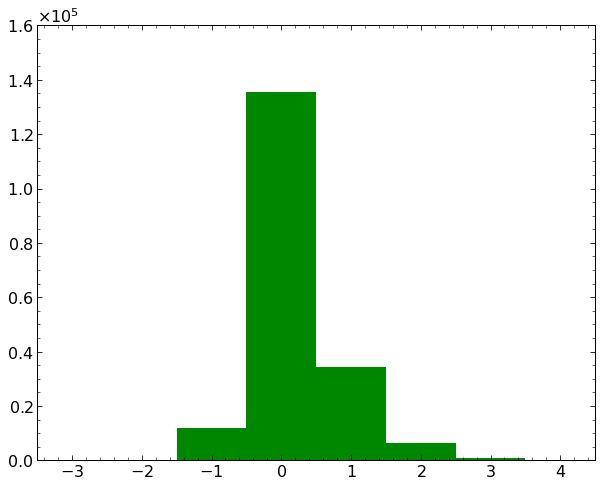

mean: +2.e+00
std: +1.e+00

-- boostedJets_nTracks --
----------------------------------------


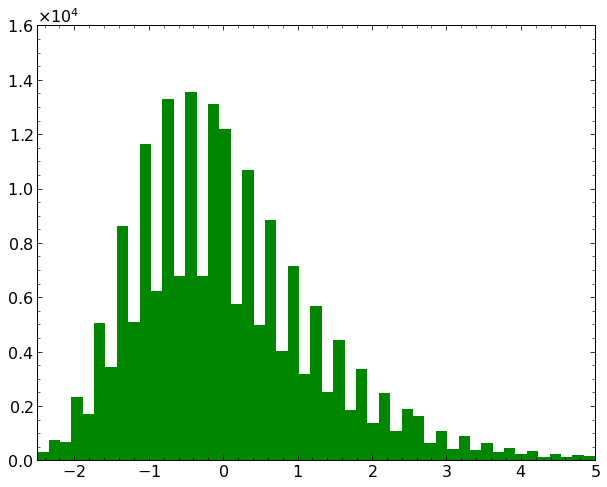

mean: +3.4e+01
std: +1.e+01

-- boostedJets_ungrtrk500 --
----------------------------------------


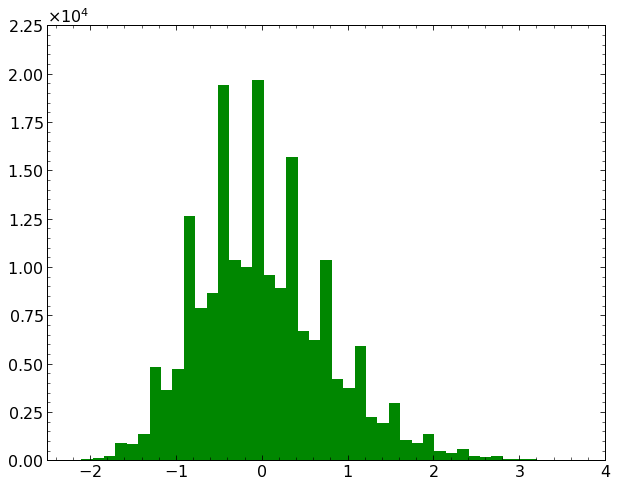

mean: +2.6e+01
std: +1.e+01

-- boostedJets_numConstituents --
----------------------------------------


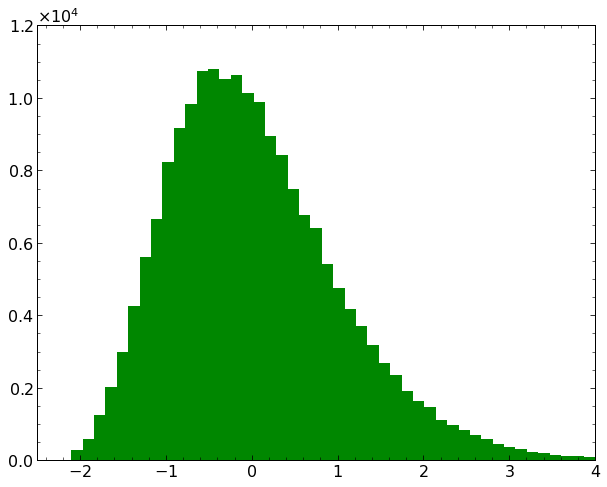

mean: +1.862e+01
std: +7.585e+00



In [19]:
for key in boostedJets_keys:

    var_mean = boostedJets_norm_mean[key][0]
    var_std = boostedJets_norm_mean[key][1]
    # Show the histograms of flattened variables
    
    A = boostedJets_normalized[key].flatten()
    print('-- {} --'.format(key))
    print('-'*40)
    bons = plot_norm_dict[key]['bins']
    plt.hist(A, bins=bons)
    plt.xlim(bons[0], bons[-1])
    plt.show()
    mean_sci = np.format_float_scientific(var_mean, precision=3, sign=True)
    std_sci = np.format_float_scientific(var_std, precision=3, sign=True)
    print('mean: {}'.format(mean_sci))
    print('std: {}'.format(std_sci))
    print()

## Fill Arrays With Relevant Variables
### Truth
Note this has to be done in a loop because in rare cases the truth leading pt does not match the reconstructed leading pt geometrically, rather the geometric match is switched in order of pt

In [20]:
Y = np.empty((matched_jets.shape[0],2))

In [21]:
t0 = cput()
for i in range(matched_jets.shape[0]):
    evt, ld_idx, sld_idx = matched_jets[i,:]
    
    # Truth Jet
    ''' in rare circumstances these can be mismatched with reco
    jets so we need to be consistent with this! '''
    Y[i,0] = truthJets_dict['truthjet_antikt10_m'][evt][ld_idx]
    Y[i,1] = truthJets_dict['truthjet_antikt10_m'][evt][sld_idx]
t1 = cput()
print('{} (s)'.format(t1 - t0))

14.10584274190478 (s)


### Normalize Target

In [22]:
Yn = (Y - 1e5) / 1e5 #this is in MeV

### Target

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tex Gyre Heros, Helvetica, Nimbus Sans, FreeSans, Arial


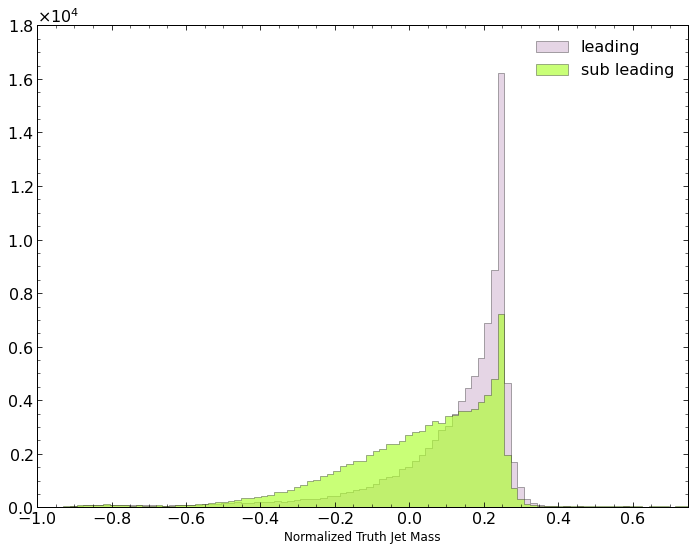

In [23]:
# This is an artifact of how we viewd the unnormalized target
target_bins = np.linspace(0,175,100,endpoint=True)
targetn_bins = (target_bins - 1e2) / 1e2 #because of MeV to GeV as above

plt.hist(Yn[:,0], bins=targetn_bins, label='leading', alpha=.65, color='thistle',
        edgecolor='black', histtype='stepfilled')
plt.hist(Yn[:,1], bins=targetn_bins, label='sub leading', alpha=.65,
         color='greenyellow', edgecolor='black', histtype='stepfilled')
plt.xlim(np.min(targetn_bins), np.max(targetn_bins))
plt.xlabel('Normalized Truth Jet Mass', fontsize=12)
plt.legend()
plt.tight_layout()
# plt.savefig('Plots/Sept22/truthJetMass_normalized.png')
plt.show()

### Reconstructed Jets

In [24]:
Nvars = len(boostedJets_keys)
print(Nvars)
nEvts_new = boostedJets_normalized[boostedJets_keys[0]].shape[0]
print(nEvts_new)

20
94741


In [25]:
X_all = np.empty((nEvts_new, 2*Nvars))

X_nomass_list, X_nomasspt_list = [], []
for j, key in enumerate(boostedJets_keys):
    # leading jet, take the 0th index
    X_all[:,j] = boostedJets_normalized[key][:,0]
    # subleading jet
    X_all[:,j+Nvars-1] = boostedJets_normalized[key][:,1]
    
    # these lists control variables to train on!
    if not key == 'boostedJets_m':
        X_nomass_list.append(key)
    if not key in ['boostedJets_m', 'boostedJets_pt']:
        X_nomasspt_list.append(key)
        
# create an X array which has the same number of features as the list
X_nomass = np.empty((nEvts_new, 2*(Nvars -1 )))
skip = int(np.floor(len(X_nomass_list)))
for j, key in enumerate(X_nomass_list):
    j2 = j + skip
    X_nomass[:,j] = boostedJets_normalized[key][:,0]
    X_nomass[:,j2] = boostedJets_normalized[key][:,1]

# similarly, xnomass_pt does not have mass or pt for the jets
X_nomasspt = np.empty((nEvts_new, 2*(Nvars -2 )))
skip = int(np.floor(len(X_nomasspt_list)))
for j, key in enumerate(X_nomasspt_list):
    j2 = j + skip
    X_nomasspt[:,j] = boostedJets_normalized[key][:,0]
    X_nomasspt[:,j2] = boostedJets_normalized[key][:,1]

### Split Variables for Training and Testing

In [26]:
NTrain, NVal, NTest = tvt_num(Yn, (70,15,15))
print('*'+'-'*28+'*')
print('  -- TRAINING STATISTICS --')
print('-'*30)
print('Training   :  {}'.format(NTrain))
print('Validation :  {}'.format(NVal))
print('Testing    :  {}'.format(NTest))
print('*'+'-'*28+'*')

*----------------------------*
  -- TRAINING STATISTICS --
------------------------------
Training   :  66319
Validation :  14211
Testing    :  14211
*----------------------------*


In [27]:
X_all_tr = X_all[:NTrain,:]
X_all_val = X_all[NTrain:NVal+NTrain,:]
X_all_test = X_all[NVal+NTrain:,:]

X_nomass_tr = X_nomass[:NTrain,:]
X_nomass_val = X_nomass[NTrain:NVal+NTrain,:]
X_nomass_test = X_nomass[NVal+NTrain:,:]

X_nomasspt_tr = X_nomasspt[:NTrain,:]
X_nomasspt_val = X_nomasspt[NTrain:NVal+NTrain,:]
X_nomasspt_test = X_nomasspt[NVal+NTrain:,:]

Yn_tr = Yn[:NTrain,:]
Yn_val = Yn[NTrain:NVal+NTrain,:]
Yn_test = Yn[NVal+NTrain:,:]

print(' -- X all --')
print(X_all_tr.shape)
print(X_all_val.shape)
print(X_all_test.shape);print()

print(' -- X no mass --')
print(X_nomass_tr.shape)
print(X_nomass_val.shape)
print(X_nomass_test.shape);print()

print(' -- X no mass or pt --')
print(X_nomasspt_tr.shape)
print(X_nomasspt_val.shape)
print(X_nomasspt_test.shape);print()

 -- X all --
(66319, 40)
(14211, 40)
(14211, 40)

 -- X no mass --
(66319, 38)
(14211, 38)
(14211, 38)

 -- X no mass or pt --
(66319, 36)
(14211, 36)
(14211, 36)



## TensorFlow

In [28]:
from ml_mass_regression_models import Dumb_Network, DNN_wDropout, Split_Network
import tensorflow as tf
from tensorflow import keras

import os
os.environ['CUDA_VISIBLE_DEVICES'] = "2"
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

## Define Models

In [29]:
allvars_model = Dumb_Network(num_features=X_all_tr.shape[1], name='DNN_all_variables')
allvars_model.compile(loss='mse', optimizer=keras.optimizers.Adam(
    learning_rate=.002))
allvars_model.summary()

Model: "DNN_all_variables"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 40)]              0         
_________________________________________________________________
dense_0 (Dense)              (None, 100)               4100      
_________________________________________________________________
activation_0 (Activation)    (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
activation_1 (Activation)    (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
activation_2 (Activation)    (None, 100)         

2023-02-08 09:46:28.324238: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-02-08 09:46:28.324312: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9671 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:3d:00.0, compute capability: 7.5


In [30]:
nomass_model = Dumb_Network(num_features=X_nomass_tr.shape[1], name='DNN_nomass')
nomass_model.compile(loss='mse', optimizer=keras.optimizers.Adam(
    learning_rate=.002))
nomass_model.summary()

Model: "DNN_nomass"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 38)]              0         
_________________________________________________________________
dense_0 (Dense)              (None, 100)               3900      
_________________________________________________________________
activation_0 (Activation)    (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
activation_1 (Activation)    (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
activation_2 (Activation)    (None, 100)               0

In [31]:
nomasspt_model = Dumb_Network(num_features=X_nomasspt_tr.shape[1], name='DNN_nomass_pt')
nomasspt_model.compile(loss='mse', optimizer=keras.optimizers.Adam(
    learning_rate=.002))
nomasspt_model.summary()

Model: "DNN_nomass_pt"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 36)]              0         
_________________________________________________________________
dense_0 (Dense)              (None, 100)               3700      
_________________________________________________________________
activation_0 (Activation)    (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
activation_1 (Activation)    (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
activation_2 (Activation)    (None, 100)             

## Train Models

In [32]:
allvars_history = allvars_model.fit(
                X_all_tr,
                Yn_tr,
                validation_data=(X_all_val, Yn_val),
                shuffle=True,
                epochs=100,
                batch_size=6000)

2023-02-08 09:46:29.328340: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
12/12 [==============================] - 1s 21ms/step - loss: 0.0992 - val_loss: 0.0453
Epoch 2/100
12/12 [==============================] - 0s 7ms/step - loss: 0.0356 - val_loss: 0.0299
Epoch 3/100
12/12 [==============================] - 0s 6ms/step - loss: 0.0275 - val_loss: 0.0255
Epoch 4/100
12/12 [==============================] - 0s 6ms/step - loss: 0.0239 - val_loss: 0.0231
Epoch 5/100
12/12 [==============================] - 0s 7ms/step - loss: 0.0219 - val_loss: 0.0215
Epoch 6/100
12/12 [==============================] - 0s 7ms/step - loss: 0.0207 - val_loss: 0.0207
Epoch 7/100
12/12 [==============================] - 0s 6ms/step - loss: 0.0199 - val_loss: 0.0200
Epoch 8/100
12/12 [==============================] - 0s 6ms/step - loss: 0.0194 - val_loss: 0.0195
Epoch 9/100
12/12 [==============================] - 0s 7ms/step - loss: 0.0189 - val_loss: 0.0191
Epoch 10/100
12/12 [==============================] - 0s 6ms/step - loss: 0.0185 - val_loss: 0.0188
Epoch 11

In [33]:
nomass_history = nomass_model.fit(
                X_nomass_tr,
                Yn_tr,
                validation_data=(X_nomass_val, Yn_val),
                shuffle=True,
                epochs=100,
                batch_size=6000)

Epoch 1/100
12/12 [==============================] - 1s 16ms/step - loss: 0.0623 - val_loss: 0.0361
Epoch 2/100
12/12 [==============================] - 0s 7ms/step - loss: 0.0331 - val_loss: 0.0295
Epoch 3/100
12/12 [==============================] - 0s 6ms/step - loss: 0.0270 - val_loss: 0.0261
Epoch 4/100
12/12 [==============================] - 0s 6ms/step - loss: 0.0243 - val_loss: 0.0237
Epoch 5/100
12/12 [==============================] - 0s 6ms/step - loss: 0.0227 - val_loss: 0.0224
Epoch 6/100
12/12 [==============================] - 0s 6ms/step - loss: 0.0217 - val_loss: 0.0218
Epoch 7/100
12/12 [==============================] - 0s 6ms/step - loss: 0.0211 - val_loss: 0.0212
Epoch 8/100
12/12 [==============================] - 0s 6ms/step - loss: 0.0204 - val_loss: 0.0205
Epoch 9/100
12/12 [==============================] - 0s 6ms/step - loss: 0.0199 - val_loss: 0.0200
Epoch 10/100
12/12 [==============================] - 0s 6ms/step - loss: 0.0194 - val_loss: 0.0200
Epoch 11

In [34]:
nomasspt_history = nomasspt_model.fit(
                X_nomasspt_tr,
                Yn_tr,
                validation_data=(X_nomasspt_val, Yn_val),
                shuffle=True,
                epochs=100,
                batch_size=6000)

Epoch 1/100
12/12 [==============================] - 0s 13ms/step - loss: 0.0663 - val_loss: 0.0370
Epoch 2/100
12/12 [==============================] - 0s 6ms/step - loss: 0.0311 - val_loss: 0.0277
Epoch 3/100
12/12 [==============================] - 0s 6ms/step - loss: 0.0259 - val_loss: 0.0246
Epoch 4/100
12/12 [==============================] - 0s 6ms/step - loss: 0.0237 - val_loss: 0.0229
Epoch 5/100
12/12 [==============================] - 0s 6ms/step - loss: 0.0223 - val_loss: 0.0219
Epoch 6/100
12/12 [==============================] - 0s 6ms/step - loss: 0.0215 - val_loss: 0.0213
Epoch 7/100
12/12 [==============================] - 0s 6ms/step - loss: 0.0207 - val_loss: 0.0208
Epoch 8/100
12/12 [==============================] - 0s 6ms/step - loss: 0.0202 - val_loss: 0.0203
Epoch 9/100
12/12 [==============================] - 0s 6ms/step - loss: 0.0198 - val_loss: 0.0199
Epoch 10/100
12/12 [==============================] - 0s 6ms/step - loss: 0.0194 - val_loss: 0.0196
Epoch 11

## View Results

In [35]:
results_keys = ['all_vars', 'nomass', 'nomasspt']
results = [allvars_history, nomass_history, nomasspt_history]
results_dict = dict(zip(results_keys, results))

/tmp/ipykernel_42957/4070956253.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tex Gyre Heros, Helvetica, Nimbus Sans, FreeSans, Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Tex Gyre Heros, Helvetica, Nimbus Sans, FreeSans, Arial


Key: all_vars
Color: mediumvioletred
Key: nomass
Color: slateblue
Key: nomasspt
Color: g


<Figure size 720x576 with 0 Axes>

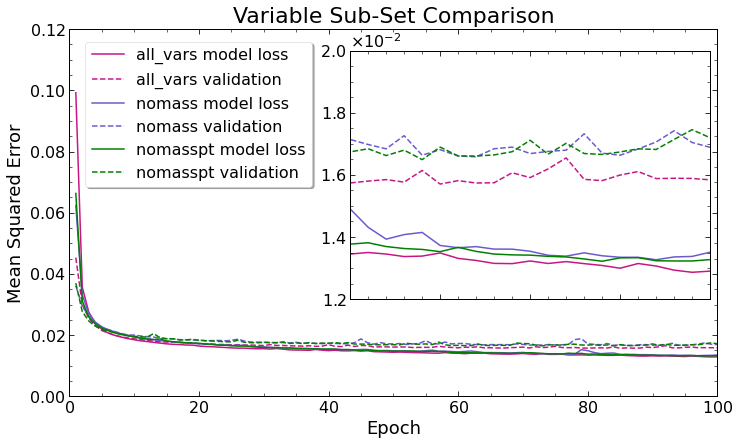

In [36]:
loss_curve_colors = ['mediumvioletred', 'slateblue', 'g', 'orangered']

# get the epochs
plt.cla(); plt.clf()
fig = plt.figure(figsize=(10,6))
dnn_loss = np.array(allvars_history.history['loss'])
epoch = np.arange(1,len(dnn_loss)+1,1)

ax1 = fig.add_axes([.075,.1,.9,.85])
ax2 = fig.add_axes([.465,.325,.5,.575])

for (color, (key, hist)) in zip(loss_curve_colors, results_dict.items()):
    print('Key: {}'.format(key))
    print('Color: {}'.format(color))
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']    
    ax1.plot(epoch, loss, label='{} model loss'.format(key), ls='solid',
             color=color)
    ax1.plot(epoch, val_loss, label='{} validation'.format(key),
             ls='dashed', color=color)
    ax2.plot(epoch, loss, ls='solid',
             color=color)
    ax2.plot(epoch, val_loss,
             ls='dashed', color=color)

# Axis 1
ax1.set_title('Variable Sub-Set Comparison', fontsize=22)
ax1.set_xlim(0,len(dnn_loss))
ax1.set_xlabel('Epoch', fontsize=18)
ax1.set_ylabel('Mean Squared Error', fontsize=18)

# Axis 2
ax2.set_xlim(80,100)
ax2.set_ylim(.012,.020)
ax2.set_xticklabels([])

# Figure
fig.legend(fontsize=16, loc=[.115,.58], frameon=True, shadow=True, fancybox=True)
plt.tight_layout()
fig.savefig('Plots/Presentation_Feb23/AllVariables_nomassComparison_lossCurves.png',
            format='png')
fig.show()

### Compare Results to Old Results

In [37]:
import pickle as pkl

with open('Data/large_dnn_history', 'rb') as pkl_obj:
    old_dnn_history = pkl.load(pkl_obj)

Key: old_dnn
Color: orange
Key: all_vars
Color: mediumblue


/tmp/ipykernel_42957/2082513534.py:46: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 720x576 with 0 Axes>

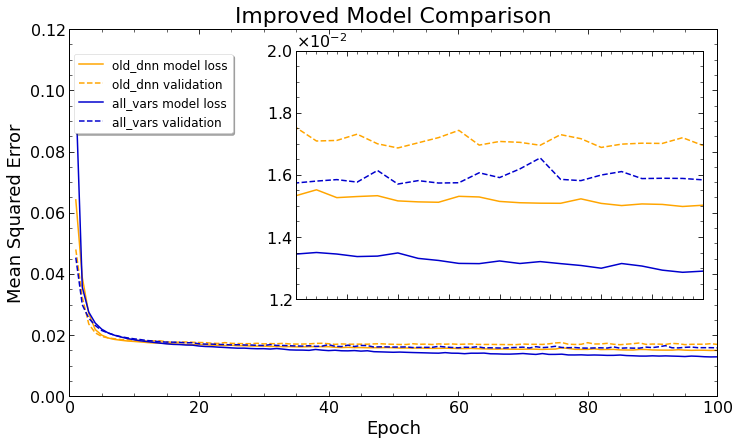

In [39]:
# as a note we have to take the history because the pickle file could only
# pickle the history therefore we need to take the history object from the
# allvars history as well :-)
compare_dict = dict()
compare_dict['old_dnn'] = old_dnn_history
compare_dict['all_vars'] = allvars_history.history

loss_curve_colors = ['orange', 'mediumblue']

# get the epochs
plt.cla(); plt.clf()
fig = plt.figure(figsize=(10,6))
dnn_loss = np.array(allvars_history.history['loss'])
epoch = np.arange(1,len(dnn_loss)+1,1)

ax1 = fig.add_axes([.075,.1,.9,.85])
ax2 = fig.add_axes([.39,.325,.565,.575])

for (color, (key, hist)) in zip(loss_curve_colors, compare_dict.items()):
    print('Key: {}'.format(key))
    print('Color: {}'.format(color))
    loss = hist['loss']
    val_loss = hist['val_loss']    
    ax1.plot(epoch, loss, label='{} model loss'.format(key), ls='solid',
             color=color)
    ax1.plot(epoch, val_loss, label='{} validation'.format(key),
             ls='dashed', color=color)
    ax2.plot(epoch, loss, ls='solid',
             color=color)
    ax2.plot(epoch, val_loss,
             ls='dashed', color=color)

# Axis 1
ax1.set_title('Improved Model Comparison', fontsize=22)
ax1.set_xlim(0,len(dnn_loss))
ax1.set_xlabel('Epoch', fontsize=18)
ax1.set_ylabel('Mean Squared Error', fontsize=18)

# Axis 2
ax2.set_xlim(80,100)
ax2.set_ylim(.012,.020)
ax2.set_xticklabels([])

# Figure
fig.legend(fontsize=12, loc=[.1,.7], frameon=True, shadow=True, fancybox=True)
plt.tight_layout()
fig.savefig('Plots/Presentation_Feb23/NewOldComparison_lossCurves.png', format='png')
fig.show()